In [4]:
import warnings

import numpy as np
from sklearn import svm
from sklearn.base import clone
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, RepeatedStratifiedKFold, train_test_split
from sklearn.neural_network import MLPClassifier

import parse_stroke_data_file

# TODO: MANAGE WITH THIS SOMEHOW
warnings.filterwarnings("ignore")


# Opis środowiska eksperymentalnego

Ewaluacja każdego klasyfikatora była wykonywana
z wykorzystaniem pięciokrotnie powtarzanej metody
2-krotnej walidacji krzyżowej

In [ ]:
N_SPLITS = 2
N_REPEATS = 5

Badania były przeprowadzane dla różnej
liczby cech. Poczynając od jednej - najlepszej, według rankingu cech wyznaczonego za pomocą `SelectKBest`,
kolejno dodawane były kolejne cechy. Nasz zbiór danych miał 59 cech.


In [ ]:
FEATURES_RANGE = range(1,60)

Do treningu wykorzystana została sieć jednokierunkowa z jedną warstwą ukrytą.
Sprawdziliśmy 3 różne liczby neuronów w warstwie ukrytej: 20, 50 oraz 90.
Przetestowane zostały klasyfikatory z parametrem `momentum` (bezwładność) o wartościach:

- 0: brak bezwładności
- 0.9: domyślna bezwładność w dla sztucznych sieci neuronowych

In [ ]:
HIDDEN_LAYER_SIZES = [20, 50, 90]
MOMENTUM_VALUES = [0.0, 0.9]

# Implementacja środowiska eksperymentalnego

Kluczową część środowiska stanowi funkcja, generująca klasyfikatory. Każdy klasyfikator otrzymuje unikatową nazwę, opisującą jego konfigurację (liczbę cech, ilośc neuronów w ukrytych warstwach, wartość parametru `momentum`).

In [7]:
def get_classifiers():
    classifiers = {}
    for num_of_features in FEATURES_RANGE:
        for hidden_layer_size in HIDDEN_LAYER_SIZES:
            for momentum_value in MOMENTUM_VALUES:
                new_classifier = MLPClassifier(
                    hidden_layer_sizes=(hidden_layer_size,), momentum=momentum_value
                )

                new_classifier.num_of_features = num_of_features

                classifiers[
                    f"features_{num_of_features}"
                    f"__hidden_{hidden_layer_size}"
                    f"__momentum_{momentum_value}"
                ] = new_classifier

    return classifiers

Po wczytaniu zbioru uczącego, następuje ewaluacja każdego z klasyfikatorów. Proces ewaluacji składa się z:

- Załadowania odpowiedniego podzbioru zbioru uczącego (określonego przez liczbę cech, na jakich ma być trenowany klasyfikator)
- Pięciokrotna ewaluacja klasyfikatora na zbiorze danych, uczących i testowych, wygenerowanych za pomocą metody walidacji krzyżowej
- Zapisania sprawności klasyfikatora, policzonej za pomocą metody `accuracy_score`

Gdy wszystkie klasyfikatory zostały ocenione, ich sprawności zostają zapisane do pliku `results.npy`.

In [6]:
if __name__ == "__main__":
    X, y = parse_stroke_data_file.get_dataset_x_y()
    rskf = RepeatedStratifiedKFold(
        n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=42
    )  # haha śmieszna liczba 42 haha
    classifiers = get_classifiers()

    scores = np.zeros((len(classifiers), N_SPLITS * N_REPEATS))

    for clf_id, clf_name in enumerate(classifiers):
        X_new = SelectKBest(
            chi2, k=classifiers[clf_name].num_of_features
        ).fit_transform(X, y)

        for fold_id, (train, test) in enumerate(rskf.split(X_new, y)):
            clf = clone(classifiers[clf_name])
            clf.fit(X[train], y[train])
            y_pred = clf.predict(X[test])
            scores[clf_id, fold_id] = accuracy_score(y[test], y_pred)

    mean = np.mean(scores, axis=1)
    std = np.std(scores, axis=1)

    for clf_id, clf_name in enumerate(classifiers):
        print("%s: %.3f (%.2f)" % (clf_name, mean[clf_id], std[clf_id]))

    np.save("results", scores)

# Analiza wyników

## Sprawność klasyfikatorów a rozmiar warstwy ukrytej

Pierwszym krokiem podjętym w celu przeanalizowania wyników było utworzenie wykresu ilustrującego uzyskaną 
przez klasyfikatory sprawność, w zależności od liczby neuronów w ukrytych warstwach.

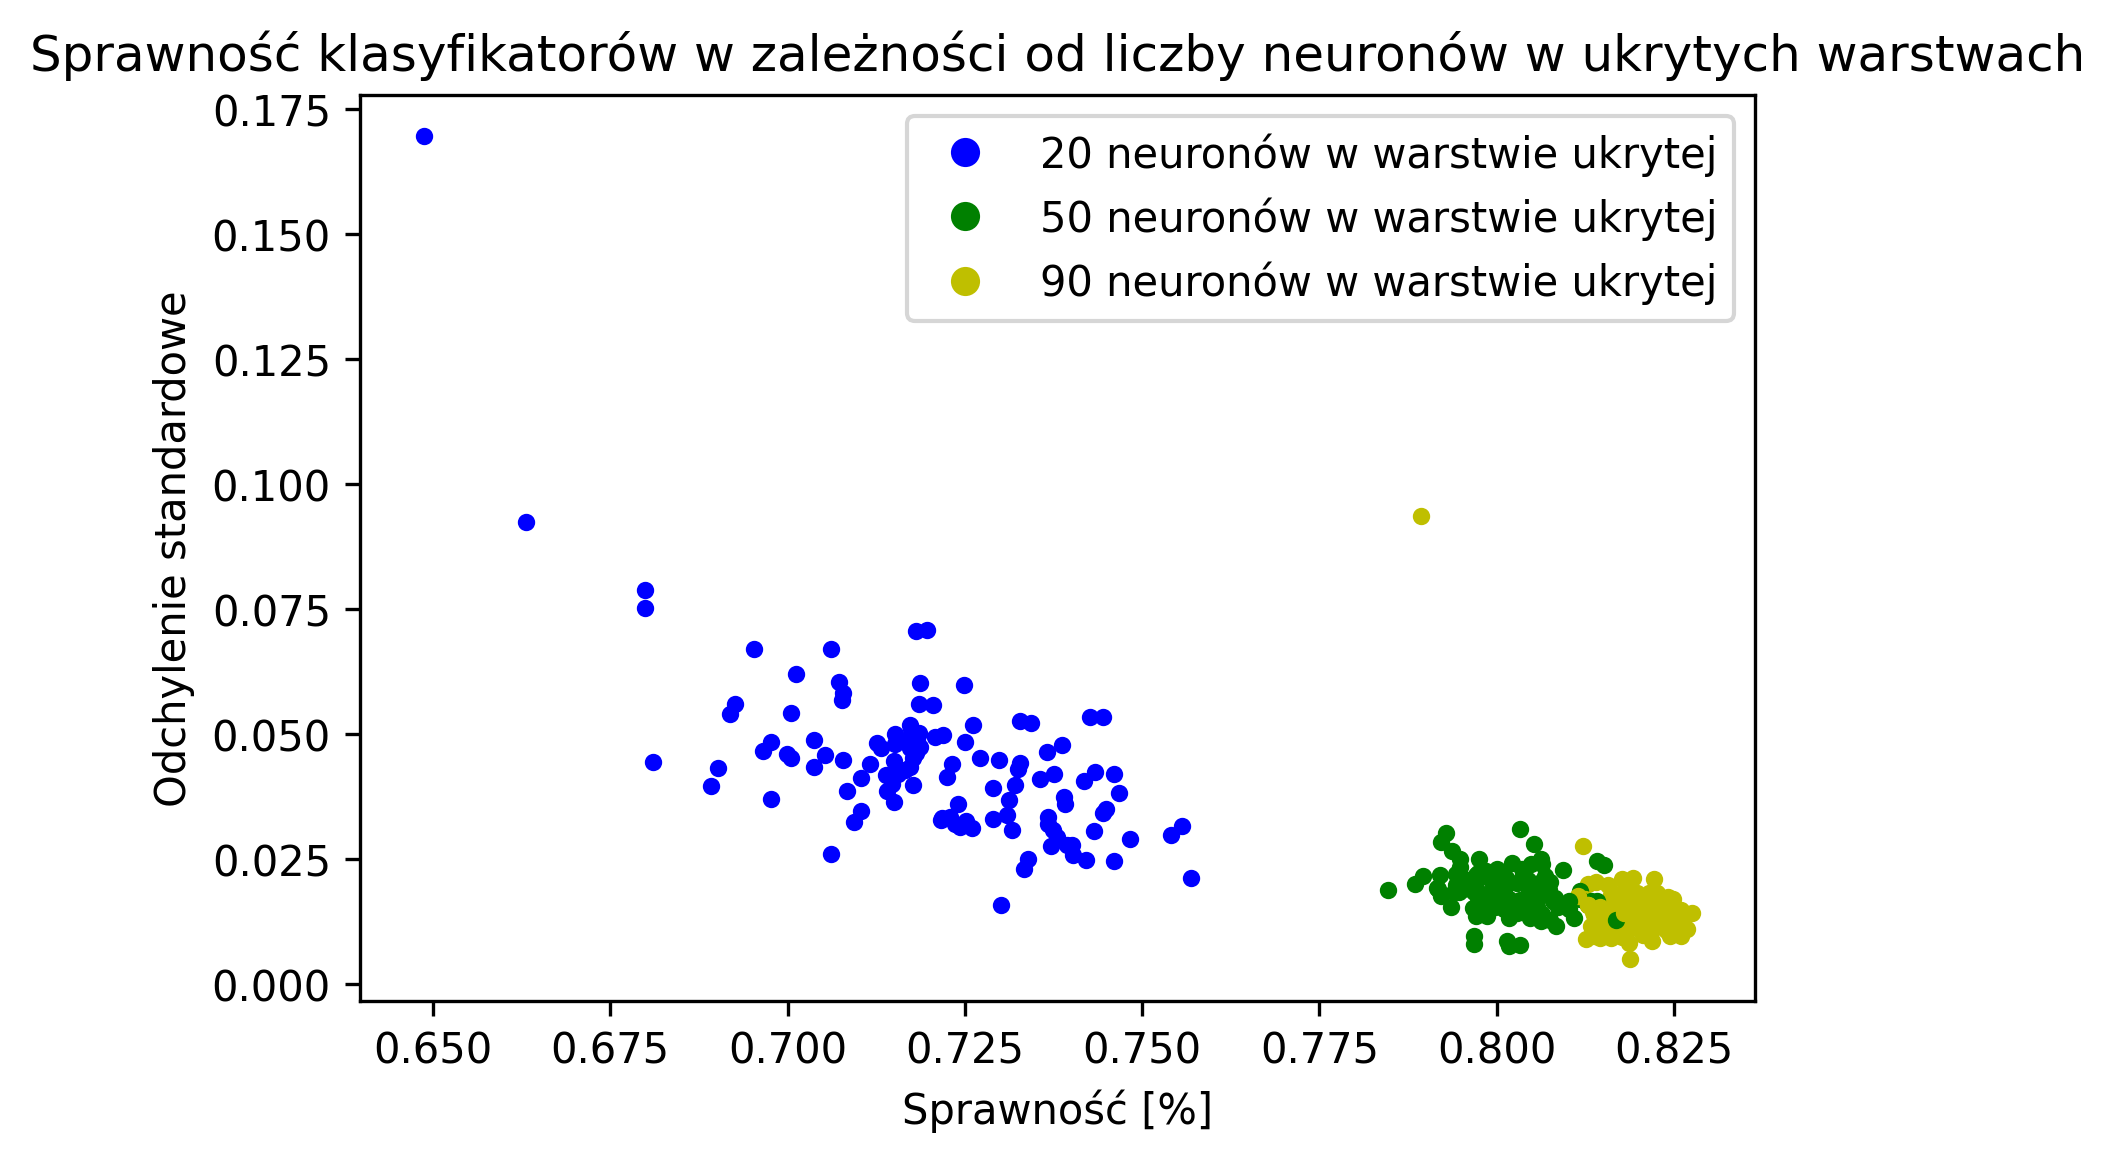

In [25]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D

matplotlib.rcParams['figure.dpi'] = 300

clfs = get_classifiers()
scores = np.load("results.npy")
fig, ax = plt.subplots()
for score, classifier in zip(scores, clfs):
    color = "r"
   
    if "hidden_20" in classifier:
        color = "b"
    if "hidden_50" in classifier:
        color = "g"
    if "hidden_90" in classifier:
        color = "y"

    mean = np.mean(score)
    std = np.std(score)

    ax.scatter(mean, std, c=color, marker='o', s=10)
    ax.set_xlabel('Sprawność [%]')
    ax.set_ylabel('Odchylenie standardowe')
    plt.title('Sprawność klasyfikatorów w zależności od liczby neuronów w ukrytych warstwach')


legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='20 neuronów w warstwie ukrytej', markerfacecolor='b', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='50 neuronów w warstwie ukrytej', markerfacecolor='g', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='90 neuronów w warstwie ukrytej', markerfacecolor='y', markersize=8),
]


ax.legend(handles=legend_elements)
plt.show()

Na wykresie widocznie dostrzegalna jest przewaga klasyfikatorów o większej liczbie neuronów w warstwie ukrytej. 
Zarówno pod względem sprawności jak i odchylenia standardowego, są one lepsze niż klasyfikatory o małej liczbie 
neuronów w warstwie ukrytej.